<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Pig_GaussionAdversorial_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
import json
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();
pred = model(norm(pig_tensor))


with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

--2021-09-10 15:47:47--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.08s   

2021-09-10 15:47:48 (449 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Arctic_fox
3.3335182666778564
Predicted probability: 0.1679898202419281


chow
2.862917184829712
Predicted probability: 0.13999244570732117


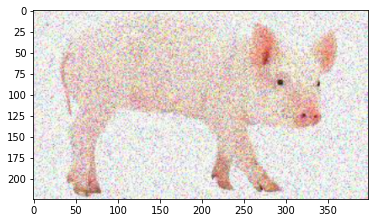

In [11]:

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

pig_img = Image.open("pig_gaussian.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor_gassian = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor_gassian[0].numpy().transpose(1,2,0))
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

pred = model(norm(pig_tensor_gassian))

max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print(nn.CrossEntropyLoss()(model(norm(pig_tensor_gassian)),torch.LongTensor([341])).item())
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


In [20]:
delta = torch.zeros_like(pig_tensor_gassian, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(200):
    pred = model(norm(pig_tensor_gassian + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 9.61292552947998
10 -2.731869697570801
20 -7.271421432495117
30 -10.690484046936035
40 -13.526073455810547
50 -16.265090942382812
60 -18.95262908935547
70 -21.796985626220703
80 -24.378559112548828
90 -26.850618362426758
100 -28.918630599975586
110 -31.465181350708008
120 -32.62168884277344
130 -34.60528564453125
140 -35.40023422241211
150 -36.88444137573242
160 -37.43362045288086
170 -38.421241760253906
180 -39.20443344116211
190 -39.42601776123047


In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

obj= (pig_tensor_gassian+delta)[0].detach().numpy().transpose(1,2,0)
plt.imsave("pig_GaussionAdvisorial.jpg", np.clip(obj, 0, 1))

Predicted class with Guassion-Adversorial and compression:  Arctic_fox
Predicted probability: 0.09829186648130417
True class [Pig] probability: 0.0021250522695481777


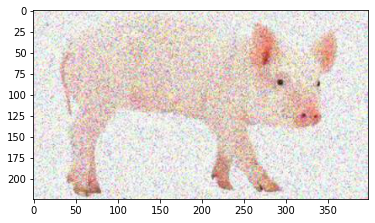

In [34]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_obj = Image.open("pig_GaussionAdvisorial.jpg")
#pig_obj = Image.open("pig_GaussianAdversarial_screenshot.jpg")
#pig_obj = Image.open("pig_gaussian.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_obj)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

pred = model(norm(pig_tensor))
max_class = pred.max(dim=1)[1].item()
print("Predicted class with Guassion-Adversorial and compression: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
print("True class [Pig] probability:", nn.Softmax(dim=1)(pred)[0,341].item())

True class probability: 0.034994639456272125
